In [1]:
import os
import networkx as nx
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import MinMaxScaler
import itertools


D:\Anaconda\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
D:\Anaconda\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
D:\Anaconda\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
##read node feature
data_dir = os.path.expanduser(".\\pubmed-diabetes\\data")
def parse_line(line):
    pid, raw_label, *raw_features, _summary = line.split("\t")
    features = dict(parse_feature(feat) for feat in raw_features)
    features["pid"] = int(pid)
    features["label"] = int(parse_feature(raw_label)[1])
    return features
def parse_feature(feat):
    name, value = feat.split("=")
    return name, float(value)
node_path=os.path.join(data_dir, "Pubmed-Diabetes.NODE.paper.tab")
with open(node_path) as fp:
            node_data = pd.DataFrame(
                parse_line(line) for line in itertools.islice(fp, 2, None)
            )

In [3]:
## fill na with 0, set id
node_data.fillna(0.0, inplace=True)
node_data.set_index("pid", inplace=True)

labels = node_data["label"]
nodes = node_data.drop(columns="label")
nodes.shape

(19717, 500)

In [4]:
zero_frame=pd.DataFrame((nodes == 0).astype(int).sum(axis=0)).sort_values(0)
zero_frame.columns=["n_zero"]
zero_frame[zero_frame["n_zero"]<16000].shape

(58, 1)

In [5]:
16000/19717

0.8114824770502612

In [6]:
feature_list=list(zero_frame[zero_frame["n_zero"]<16000].reset_index()["index"])
feature_list.append("label")
feature_list[:10]

['w-studi',
 'w-2',
 'w-1',
 'w-type',
 'w-result',
 'w-control',
 'w-increas',
 'w-signific',
 'w-0',
 'w-patient']

In [7]:
node_feature=node_data[feature_list]
pid_list=pd.DataFrame((node_feature != 0).astype(int).sum(axis=1)).sort_values(0,ascending=False)
pid_list.columns=["non_zero"]
pid_list[pid_list["non_zero"]>30].shape

(887, 1)

In [8]:
non_zero_list=pid_list[pid_list["non_zero"]>30].reset_index()
data_new=non_zero_list.merge(node_feature,on="pid",how="inner")

In [9]:
#train/test split
import utils as ut
import random
torch.manual_seed(12345)
ut.set_random_seed(12345)
n=data_new.shape[0]
all_list=[i for i in range(n)]
random.shuffle(all_list)
data_new[["train_mask","valid_mask","test_mask"]]=False
data_new.loc[all_list[:int(n*0.4)],"train_mask"]=True
data_new.loc[all_list[int(n*0.4):int(n*0.8)],"valid_mask"]=True
data_new.loc[all_list[int(n*0.8):],"test_mask"]=True


Bad key "text.kerning_factor" on line 4 in
D:\Anaconda\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [10]:
#binary label, binary feature
data_new.loc[data_new["label"]!=3,"label"]=0
data_new=data_new.drop(columns="non_zero")
node_scaled=data_new.copy()
node_scaled=node_scaled.drop(columns="pid")
# scaler = MinMaxScaler()
# node_scaled = pd.DataFrame(scaler.fit_transform(node_scaled), columns=node_scaled.columns)
node_scaled[node_scaled != 0] = 1.0
node_scaled

,w-studi,w-2,w-1,w-type,w-result,w-control,w-increas,w-signific,w-0,w-patient,...,w-10,w-higher,w-9,w-data,w-rat,w-howev,label,train_mask,valid_mask,test_mask
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,0.0,0.0,1.0,1,1.0,0.0,0.0
1,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1,1.0,0.0,0.0
2,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,...,1.0,0.0,1.0,1.0,0.0,1.0,1,0.0,1.0,0.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,0.0,0.0,1.0,1,0.0,0.0,1.0
4,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,...,1.0,0.0,1.0,1.0,0.0,1.0,1,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
882,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1,0.0,1.0,0.0
883,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,...,1.0,0.0,1.0,1.0,1.0,1.0,0,0.0,1.0,0.0
884,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,...,1.0,1.0,1.0,0.0,0.0,0.0,1,1.0,0.0,0.0
885,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,1,0.0,0.0,1.0


# NOTEARS

In [11]:
def notears_linear(X, lambda1, loss_type, max_iter=100, h_tol=1e-8, rho_max=1e+16, w_threshold=0.3):
    """Solve min_W L(W; X) + lambda1 ‖W‖_1 s.t. h(W) = 0 using augmented Lagrangian.

    Args:
        X (np.ndarray): [n, d] sample matrix
        lambda1 (float): l1 penalty parameter
        loss_type (str): l2, logistic, poisson
        max_iter (int): max num of dual ascent steps
        h_tol (float): exit if |h(w_est)| <= htol
        rho_max (float): exit if rho >= rho_max
        w_threshold (float): drop edge if |weight| < threshold

    Returns:
        W_est (np.ndarray): [d, d] estimated DAG
    """
    def _loss(W):
        """Evaluate value and gradient of loss."""
        M = X @ W
        if loss_type == 'l2':
            R = X - M
            loss = 0.5 / X.shape[0] * (R ** 2).sum()
            G_loss = - 1.0 / X.shape[0] * X.T @ R
        elif loss_type == 'logistic':
            loss = 1.0 / X.shape[0] * (np.logaddexp(0, M) - X * M).sum()
            G_loss = 1.0 / X.shape[0] * X.T @ (sigmoid(M) - X)
        elif loss_type == 'poisson':
            S = np.exp(M)
            loss = 1.0 / X.shape[0] * (S - X * M).sum()
            G_loss = 1.0 / X.shape[0] * X.T @ (S - X)
        else:
            raise ValueError('unknown loss type')
        return loss, G_loss

    def _h(W):
        """Evaluate value and gradient of acyclicity constraint."""
        E = slin.expm(W * W)  # (Zheng et al. 2018)
        h = np.trace(E) - d
        #     # A different formulation, slightly faster at the cost of numerical stability
        #     M = np.eye(d) + W * W / d  # (Yu et al. 2019)
        #     E = np.linalg.matrix_power(M, d - 1)
        #     h = (E.T * M).sum() - d
        G_h = E.T * W * 2
        return h, G_h

    def _adj(w):
        """Convert doubled variables ([2 d^2] array) back to original variables ([d, d] matrix)."""
        return (w[:d * d] - w[d * d:]).reshape([d, d])

    def _func(w):
        """Evaluate value and gradient of augmented Lagrangian for doubled variables ([2 d^2] array)."""
        W = _adj(w)
        loss, G_loss = _loss(W)
        h, G_h = _h(W)
        obj = loss + 0.5 * rho * h * h + alpha * h + lambda1 * w.sum()
        G_smooth = G_loss + (rho * h + alpha) * G_h
        g_obj = np.concatenate((G_smooth + lambda1, - G_smooth + lambda1), axis=None)
        return obj, g_obj

    n, d = X.shape
    w_est, rho, alpha, h = np.zeros(2 * d * d), 1.0, 0.0, np.inf  # double w_est into (w_pos, w_neg)
    bnds = [(0, 0) if i == j else (0, None) for _ in range(2) for i in range(d) for j in range(d)]
    if loss_type == 'l2':
        X = X - np.mean(X, axis=0, keepdims=True)
    for _ in range(max_iter):
        w_new, h_new = None, None
        while rho < rho_max:
            sol = sopt.minimize(_func, w_est, method='L-BFGS-B', jac=True, bounds=bnds)
            w_new = sol.x
            h_new, _ = _h(_adj(w_new))
            if h_new > 0.25 * h:
                rho *= 10
            else:
                break
        w_est, h = w_new, h_new
        alpha += rho * h
        if h <= h_tol or rho >= rho_max:
            break
    W_est = _adj(w_est)
    W_est[np.abs(W_est) < w_threshold] = 0
    return W_est

In [12]:
from scipy.special import expit as sigmoid
import scipy.optimize as sopt
import scipy.linalg as slin
import scipy.sparse as sp
from notears.locally_connected import LocallyConnected
from notears.lbfgsb_scipy import LBFGSBScipy
from notears.trace_expm import trace_expm
import torch
import torch.nn as nn
import numpy as np
import math


In [106]:
node_scaled.iloc[:,:-3].head(5)

,w-studi,w-2,w-1,w-type,w-result,w-control,w-increas,w-signific,w-0,w-patient,...,w-chang,w-dure,w-observ,w-10,w-higher,w-9,w-data,w-rat,w-howev,label
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1
1,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,...,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1
2,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,...,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1
4,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1


In [13]:
node_scaled[node_scaled["test_mask"]!=1].iloc[:,:-3]

,w-studi,w-2,w-1,w-type,w-result,w-control,w-increas,w-signific,w-0,w-patient,...,w-chang,w-dure,w-observ,w-10,w-higher,w-9,w-data,w-rat,w-howev,label
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1
1,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,...,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1
2,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,...,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1
4,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1
5,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
879,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
880,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1
882,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1
883,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0


In [14]:
dag_notear=notears_linear(node_scaled[node_scaled["test_mask"]!=1].iloc[:,:-3].to_numpy(), lambda1=0.05, loss_type="logistic", max_iter=100, h_tol=1e-8, rho_max=1e+16, w_threshold=0.2)

In [15]:
dag_notear.nonzero()

(array([ 1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,
         3,  3,  4,  4,  4,  4,  4,  4,  4,  5,  8,  8,  8,  8,  8,  8,  8,
         8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9, 10, 11, 11, 11,
        15, 16, 17, 17, 19, 19, 19, 19, 19, 21, 21, 24, 24, 26, 26, 26, 28,
        28, 28, 31, 31, 34, 35, 35, 36, 36, 36, 36, 36, 37, 44, 54, 58, 58],
       dtype=int64),
 array([ 0,  2, 24, 41, 48, 55,  6, 18, 21, 24, 25, 35, 48,  1,  8, 46, 47,
        56, 58,  1,  8, 13, 41, 46, 47, 51, 22,  0,  1,  2,  6, 11, 21, 28,
        34, 41, 48, 56, 57,  3,  5,  7,  8, 26, 30, 48, 56, 44,  5,  7, 13,
         9, 53, 10, 29,  3,  4, 25, 41, 56, 28, 35, 18, 37,  4, 19, 50, 18,
        24, 57,  9, 16, 11, 28, 54, 26, 27, 47, 51, 56, 44, 40, 37,  1, 17],
       dtype=int64))

In [16]:
len(feature_list)

59

In [114]:
target=dag_notear.nonzero()[0]
source=dag_notear.nonzero()[1]
target_label=[feature_list[i][2:] if feature_list[i]!='label' else feature_list[i] for i in target]
source_label=[feature_list[i][2:] if feature_list[i]!='label' else feature_list[i] for i in source]
dag_edge=pd.DataFrame(target_label,source_label).reset_index()
dag_edge.columns=['target','source']
dag_edge.loc[18]["target"]=dag_edge.loc[18]["source"]
dag_edge.loc[18]["source"]="label"

In [115]:
G_dag = nx.DiGraph()
G_dag.add_nodes_from(dag_edge['source'])
G_dag.add_nodes_from(dag_edge['target'])
# Add edges from the DataFrame
edges = [( row['target'],row['source']) for index, row in dag_edge.iterrows()]
G_dag.add_edges_from(edges)

In [116]:
edges

[('studi', '2'),
 ('1', '2'),
 ('4', '2'),
 ('cell', '2'),
 ('activ', '2'),
 ('data', '2'),
 ('increas', '1'),
 ('3', '1'),
 ('5', '1'),
 ('4', '1'),
 ('suggest', '1'),
 ('7', '1'),
 ('activ', '1'),
 ('2', 'type'),
 ('0', 'type'),
 ('normal', 'type'),
 ('respons', 'type'),
 ('rat', 'type'),
 ('type', 'label'),
 ('2', 'result'),
 ('0', 'result'),
 ('compar', 'result'),
 ('cell', 'result'),
 ('normal', 'result'),
 ('respons', 'result'),
 ('observ', 'result'),
 ('group', 'control'),
 ('studi', '0'),
 ('2', '0'),
 ('1', '0'),
 ('increas', '0'),
 ('p', '0'),
 ('5', '0'),
 ('6', '0'),
 ('lt', '0'),
 ('cell', '0'),
 ('activ', '0'),
 ('rat', '0'),
 ('howev', '0'),
 ('type', 'patient'),
 ('control', 'patient'),
 ('signific', 'patient'),
 ('0', 'patient'),
 ('method', 'patient'),
 ('develop', 'patient'),
 ('activ', 'patient'),
 ('rat', 'patient'),
 ('factor', 'insulin'),
 ('control', 'p'),
 ('signific', 'p'),
 ('compar', 'p'),
 ('patient', 'level'),
 ('higher', 'effect'),
 ('insulin', 'glucos'),

In [37]:
#!pip install pydot
#!pip install pygraphviz

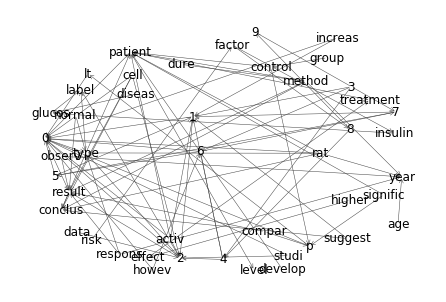

In [120]:
import matplotlib.pyplot as plt

pos = nx.spring_layout(G_dag, k=0.8, iterations=20,seed=2)
nx.draw(G_dag, with_labels = True,pos=pos, node_size=10,arrowsize=10,arrowstyle='->',edge_color="#454545",width=0.5,node_color="white")
#plt.show()
plt.savefig('estimated_dag.pdf')

## fit model

In [20]:
#edgelist
edgelist = pd.read_csv(
    os.path.join(data_dir, "Pubmed-Diabetes.DIRECTED.cites.tab"),
    sep="\t",
    skiprows=2,
    header=None,
    names=["id", "source", "pipe", "target"],
    usecols=["source", "target"],
)
edgelist.source = edgelist.source.str.lstrip("paper:").astype(int)
edgelist.target = edgelist.target.str.lstrip("paper:").astype(int)

In [21]:
#filter the edge that are remained
edgelist_filter=pd.DataFrame(columns=["source","target"])
pid_list=data_new["pid"].to_list()
pid_dict={}
for item in pid_list:
    pid_dict[item]=1
    #add self loop
    edgelist_filter=edgelist_filter.append({"source":item,"target":item}, ignore_index = True)
for i in range(len(edgelist)):
    if (edgelist.loc[i][0] in pid_dict) and (edgelist.loc[i][1] in pid_dict):
        edgelist_filter=edgelist_filter.append(edgelist.loc[i])#235 edges->1122

In [22]:
node_feature=data_new.copy()
node_feature=node_feature.set_index('pid')
node_feature[node_feature != 0] = 1.0
def convert_bool(x):
    if x==1:
        return True
    else:
        return False
node_feature["train_mask"]=node_feature["train_mask"].apply(lambda x: convert_bool(x))
node_feature["valid_mask"]=node_feature["valid_mask"].apply(lambda x: convert_bool(x))
node_feature["test_mask"]=node_feature["test_mask"].apply(lambda x: convert_bool(x))

In [23]:
node_feature

,w-studi,w-2,w-1,w-type,w-result,w-control,w-increas,w-signific,w-0,w-patient,...,w-10,w-higher,w-9,w-data,w-rat,w-howev,label,train_mask,valid_mask,test_mask
pid,,,,,,,,,,,,,,,,,,,,,
10480619,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,0.0,0.0,1.0,1,True,False,False
15978304,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1,True,False,False
12759885,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,...,1.0,0.0,1.0,1.0,0.0,1.0,1,False,True,False
12637120,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,0.0,0.0,1.0,1,False,False,True
10547211,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,...,1.0,0.0,1.0,1.0,0.0,1.0,1,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16352689,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1,False,True,False
16849625,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,...,1.0,0.0,1.0,1.0,1.0,1.0,0,False,True,False
8722051,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,...,1.0,1.0,1.0,0.0,0.0,0.0,1,True,False,False


In [24]:
#create graph
G=nx.from_pandas_edgelist(edgelist_filter)
node_attr = node_feature.iloc[:,-4:].to_dict('index')

nx.set_node_attributes(G, node_attr)
for pid in pid_list:
        G.nodes[pid]['feature']=node_feature.loc[pid][:-4].tolist()

In [25]:
import dgl
g = dgl.from_networkx(G,node_attrs=list(node_feature.columns)[-4:]+["feature"])

Using backend: pytorch


## plot citation graph

In [26]:
#new graph with no self loop, contain nodes that have edges
edgelist_filter=pd.DataFrame(columns=["source","target"])
pid_list=data_new["pid"].to_list()
pid_dict={}
for item in pid_list:
    pid_dict[item]=1
    #no self loop
    #edgelist_filter=edgelist_filter.append({"source":item,"target":item}, ignore_index = True)
for i in range(len(edgelist)):
    if (edgelist.loc[i][0] in pid_dict) and (edgelist.loc[i][1] in pid_dict):
        edgelist_filter=edgelist_filter.append(edgelist.loc[i])#235 edges->1122

In [27]:
connect_node=set(edgelist_filter["source"]).union(set(edgelist_filter["target"]))

In [28]:
#filter the edge that are remained
edgelist_plot=pd.DataFrame(columns=["source","target"])
pid_dict_plot={}
for item in connect_node:
    pid_dict_plot[item]=1
    #no self loop
for i in range(len(edgelist)):
    if (edgelist.loc[i][0] in pid_dict_plot) and (edgelist.loc[i][1] in pid_dict_plot):
        edgelist_plot=edgelist_plot.append(edgelist.loc[i])#235 edges->1122

In [29]:
#create graph
G_plot=nx.from_pandas_edgelist(edgelist_plot)
node_attr = node_feature.iloc[:,-4:].to_dict('index')

nx.set_node_attributes(G_plot, node_attr)
for pid in pid_dict_plot:
        G_plot.nodes[pid]['feature']=node_feature.loc[pid][:-4].tolist()

In [30]:
import plotly.graph_objects as go
import networkx as nx
# set node positions
pos = nx.kamada_kawai_layout(G_plot)
for node in G_plot.nodes():
    G_plot.nodes[node]['pos']= pos[node]

In [31]:
edge_x = []
edge_y = []
for edge in G_plot.edges():
    x0, y0 = G_plot.nodes[edge[0]]['pos']
    x1, y1 = G_plot.nodes[edge[1]]['pos']
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

node_x = []
node_y = []
for node in G_plot.nodes():
    x, y = G_plot.nodes[node]['pos']
    node_x.append(x)
    node_y.append(y)

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        # colorscale options
        #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
        #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
        #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
        colorscale='YlGnBu',
        reversescale=True,
        color=[],
        size=5,
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line_width=2))

In [32]:
node_adjacencies = []
node_text = []
for node, adjacencies in enumerate(G.adjacency()):
    node_adjacencies.append(len(adjacencies[1]))
    node_text.append('# of connections: '+str(len(adjacencies[1])))

node_trace.marker.color = node_adjacencies
node_trace.text = node_text

In [34]:
fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='<br>Citation graph for pubmed data',
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
#                 annotations=[ dict(
#                     text="Python code: <a href='https://plotly.com/ipython-notebooks/network-graphs/'> https://plotly.com/ipython-notebooks/network-graphs/</a>",
#                     showarrow=False,
#                     xref="paper", yref="paper",
#                     x=0.005, y=-0.002 ) ],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )
fig.show()
#fig.write_image("citation_graph.pdf")

# GCN

In [111]:
class GCNLayer(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(GCNLayer, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)

    def forward(self, g, feature):
        # Creating a local scope so that all the stored ndata and edata
        # (such as the `'h'` ndata below) are automatically popped out
        # when the scope exits.
        with g.local_scope():
            g.ndata['h'] = feature
            g.update_all(gcn_msg, gcn_reduce)
            h = g.ndata['h']
            return self.linear(h)
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layer1 = GCNLayer(58, 16)
        self.layer2 = GCNLayer(16, 2)

    def forward(self, g, features):
        x = F.relu(self.layer1(g, features))
        x = self.layer2(g, x)
        return x
def evaluate(model, g, features, labels, mask):
    model.eval()
    with torch.no_grad():
        logits = model(g, features)
        logits = logits[mask]
        labels = labels[mask]
        _, indices = torch.max(logits, dim=1)
        correct = torch.sum(indices == labels)
        return correct.item() * 1.0 / len(labels)

In [113]:
import dgl.function as fn
import torch.nn as nn
import torch.nn.functional as F
torch.set_default_dtype(torch.double)
np.set_printoptions(precision=3)

torch.manual_seed(12345)
ut.set_random_seed(12345)


d = 58 #number of features


#params
lr=0.01
early_stop_thresh=80
n_epoch=300
output=pd.DataFrame(columns=["train_acc","valid_acc","test_acc","model"])
##########################33
#GCN
gcn_msg = fn.copy_u(u="h", out="m")
gcn_reduce = fn.sum(msg="m", out="h")

net = Net()

features = g.ndata['feature']
labels = g.ndata['label']
train_mask = g.ndata['train_mask']
valid_mask = g.ndata['valid_mask']
test_mask = g.ndata['test_mask']

#parameters
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

best_loss = 99998
best_epoch = -1
for epoch in range(n_epoch):
    net.train()
    logits = net(g, features)
    logp = F.log_softmax(logits, dim=-1)
    loss = F.nll_loss(logp[train_mask], labels[train_mask])

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    ##evaluate
    net.eval()
    train_acc = evaluate(net, g, features, labels, train_mask)
    valid_acc = evaluate(net, g, features, labels, valid_mask)
    test_acc = evaluate(net, g, features, labels, test_mask)
    valid_loss = F.nll_loss(logp[valid_mask], labels[valid_mask])
    #early stop
    if valid_loss < best_loss:
        best_loss = valid_loss
        best_epoch = epoch
        #torch.save(net.state_dict(), "GCN_demo_large.pth")
    elif epoch - best_epoch > early_stop_thresh:
        print("Early stopped training at epoch %d" % epoch)
        break  # terminate the training loop
print("GCN:train",round(train_acc,2),"valid",round(valid_acc,2),"test",round(test_acc,2))

Early stopped training at epoch 108
GCN:train 0.82 valid 0.73 test 0.75


# proposed

In [157]:
class atten_Net(nn.Module):
    def __init__(self, in_feats, hid_feats, out_feats,n_node):
        super(atten_Net, self).__init__()
        self.layer1 = GCNLayer(in_feats, hid_feats)
        self.layer2 = GCNLayer(hid_feats, out_feats)
        self.att_mlp_1 = nn.Linear(n_node, hid_feats)
        self.att_mlp_2 = nn.Linear(hid_feats, 2)
        self.layer3 = GCNLayer(in_feats*2, hid_feats)
        self.layer4 = GCNLayer(hid_feats, out_feats)

    def forward(self, g, features,dag):
        ##use mlp to get attention weights
        node_att = F.relu(self.att_mlp_1(dag))
        node_att = F.softmax(self.att_mlp_2(node_att), dim=-1)
        node_weight_c = node_att[:, 0]
        node_weight_o = node_att[:, 1]
        ##attention on the causal/trival part
        feature_c = node_weight_c.view(1, -1) * features
        feature_o = node_weight_o.view(1, -1) * features
        ## apply the mask on the features
        xc = F.relu(self.layer1(g, feature_c))
        xc = self.layer2(g, xc)
        xc=F.log_softmax(xc, dim=-1)
        
        xo = F.relu(self.layer1(g, feature_o))
        xo = self.layer2(g, xo)
        xo=F.log_softmax(xo, dim=-1)
        ##xco        
        num = xc.shape[0]
        l = [i for i in range(num)]
        random.shuffle(l)
        random_idx = torch.tensor(l)
        xco = torch.cat((feature_c[random_idx], feature_o), dim=1)
        xco = F.relu(self.layer3(g, xco))
        xco = self.layer4(g, xco)
        xco=F.log_softmax(xco, dim=-1)
        
        return xc,xo,xco
def evaluate_new(model, g, features, labels, mask,dag):
    model.eval()
    with torch.no_grad():
        logits_c,logits_o,logits_co = model(g, features,dag)
        logits = logits_o[mask]
        labels = labels[mask]
        _, indices = torch.max(logits, dim=1)
        correct = torch.sum(indices == labels)
        return correct.item() * 1.0 / len(labels)

In [158]:
#esimated dag
dag_estimate=dag_notear
# dag_estimate=np.zeros((59,59))
# for i in range(len(dag_notear.nonzero()[0])):
#     dag_estimate[dag_notear.nonzero()[0][i],dag_notear.nonzero()[1][i]]=1

In [159]:
torch.set_default_dtype(torch.double)
np.set_printoptions(precision=3)

torch.manual_seed(12345)
ut.set_random_seed(12345)
#######
features = g.ndata['feature']
labels = g.ndata['label']
train_mask = g.ndata['train_mask']
valid_mask = g.ndata['valid_mask']
test_mask = g.ndata['test_mask']
d = 59 #number of features

#params
lr=0.005
alpha=0.5
beta=1
gamma=0.5
early_stop_thresh=80
n_epoch=300
output=pd.DataFrame(columns=["train_acc","valid_acc","test_acc","model","n_suprious"])

##proposed
model = atten_Net(in_feats=d-1, hid_feats=16, out_feats=2,n_node=d)

#params
best_loss = 0
best_epoch = -1

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
#scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
for epoch in range(n_epoch):
    model.train()
    xc_logits,xo_logits,xco_logits = model(g, features,torch.tensor(dag_estimate[:-1,:]))
    ##trivial part
    uniform_target = torch.ones_like(xc_logits[train_mask], dtype=torch.double)/2
    c_loss = F.kl_div(xc_logits[train_mask], uniform_target, reduction='batchmean')

    o_loss = F.nll_loss(xo_logits[train_mask], labels[train_mask])
    co_loss= F.nll_loss(xco_logits[train_mask], labels[train_mask])
    loss = alpha * c_loss + beta * o_loss +gamma*co_loss

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    #scheduler.step()
    ##evaluate
    model.eval()
    train_acc = evaluate_new(model, g, features, labels, train_mask,torch.tensor(dag_estimate[:-1,:]))
    valid_acc = evaluate_new(model, g, features, labels, valid_mask,torch.tensor(dag_estimate[:-1,:]))
    test_acc = evaluate_new(model, g, features, labels, test_mask,torch.tensor(dag_estimate[:-1,:]))
    #valid loss
    uniform_target = torch.ones_like(xc_logits[valid_mask], dtype=torch.float)/2
    valid_c_loss = F.kl_div(xc_logits[valid_mask], uniform_target, reduction='batchmean')
    valid_o_loss = F.nll_loss(xo_logits[valid_mask], labels[valid_mask])
    valid_co_loss = F.nll_loss(xco_logits[valid_mask], labels[valid_mask])
    valid_loss = alpha * valid_c_loss+beta *valid_o_loss+gamma*valid_co_loss
    #test loss
    test_xc_logits,test_xo_logits,test_xco_logits = model(g, features,torch.tensor(dag_estimate[:-1,:]))
    uniform_target = torch.ones_like(test_xo_logits[test_mask], dtype=torch.float)/2
    test_c_loss = F.kl_div(test_xc_logits[test_mask], uniform_target, reduction='batchmean')
    test_o_loss = F.nll_loss(test_xo_logits[test_mask], labels[test_mask])
    test_co_loss = F.nll_loss(test_xco_logits[test_mask], labels[test_mask])
    test_loss = alpha * test_c_loss + beta * test_o_loss+gamma*test_co_loss
#early stop     
    if valid_loss < best_loss:
        best_loss = valid_loss
        best_epoch = epoch
        #torch.save(model.state_dict(), "attention_demo_large.pth")
    elif epoch - best_epoch > early_stop_thresh:
        print("Early stopped training at epoch %d" % epoch)
        break  # terminate the training loop
    print("GCN:train",round(train_acc,2),"valid",round(valid_acc,2),"test",round(test_acc,2))


GCN:train 0.62 valid 0.59 test 0.6
GCN:train 0.7 valid 0.65 test 0.74
GCN:train 0.71 valid 0.65 test 0.73
GCN:train 0.71 valid 0.65 test 0.73
GCN:train 0.71 valid 0.65 test 0.73
GCN:train 0.71 valid 0.65 test 0.73
GCN:train 0.71 valid 0.65 test 0.73
GCN:train 0.71 valid 0.65 test 0.73
GCN:train 0.71 valid 0.65 test 0.73
GCN:train 0.71 valid 0.67 test 0.72
GCN:train 0.72 valid 0.66 test 0.72
GCN:train 0.72 valid 0.65 test 0.74
GCN:train 0.72 valid 0.65 test 0.74
GCN:train 0.71 valid 0.65 test 0.73
GCN:train 0.71 valid 0.65 test 0.73
GCN:train 0.71 valid 0.65 test 0.73
GCN:train 0.71 valid 0.65 test 0.73
GCN:train 0.71 valid 0.65 test 0.73
GCN:train 0.71 valid 0.65 test 0.73
GCN:train 0.71 valid 0.65 test 0.73
GCN:train 0.71 valid 0.65 test 0.74
GCN:train 0.72 valid 0.65 test 0.74
GCN:train 0.72 valid 0.65 test 0.74
GCN:train 0.71 valid 0.65 test 0.74
GCN:train 0.71 valid 0.65 test 0.73
GCN:train 0.71 valid 0.65 test 0.73
GCN:train 0.71 valid 0.65 test 0.73
GCN:train 0.71 valid 0.65 test

In [121]:
2.063/3

0.6876666666666668

In [138]:
data_new["label"].describe()

count    887.000000
mean       2.063134
std        1.391065
min        0.000000
25%        0.000000
50%        3.000000
75%        3.000000
max        3.000000
Name: label, dtype: float64

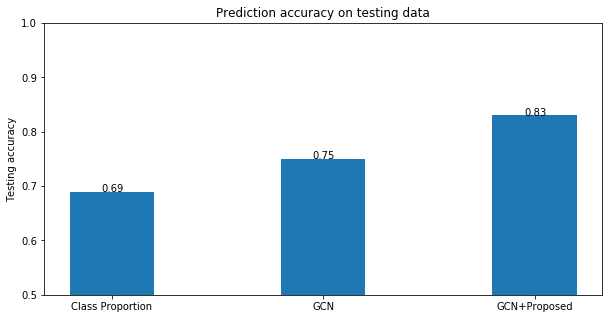

In [3]:
import numpy as np
import matplotlib.pyplot as plt 
 
  
# creating the dataset
data = {'Class Proportion':0.69, 'GCN':0.75, 'GCN+Proposed':0.83}
courses = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(courses, values, 
        width = 0.4)

plt.ylim(0.5,1)
plt.ylabel("Testing accuracy")
plt.title("Prediction accuracy on testing data")
for index, value in enumerate(values):
    plt.text(index-0.05,value,
             str(value))
plt.savefig('prediction_accuracy.pdf')

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

simu_result = pd.DataFrame(columns=["d", "GCN", "GCN-proposed","GAT","GAT-proposed"])

simu_result.loc[0]=[10,0.528,0.549,0.512,0.533]
simu_result.loc[1]=[15,0.518,0.568,0.530,0.550]
#simu_result.loc[2]=[20,0.543,0.533,0.516,0.546]

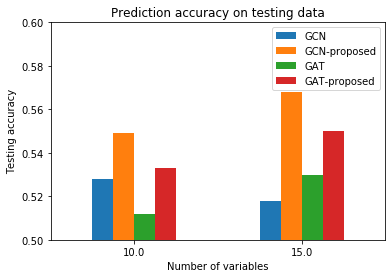

In [12]:
ax = simu_result.plot(x="d", y=["GCN", "GCN-proposed","GAT","GAT-proposed"], kind="bar", rot=0)
_ = ax.legend( loc='upper right')
plt.ylim(0.5,0.6)
plt.xlabel("Number of variables")
plt.ylabel("Testing accuracy")
plt.title("Prediction accuracy on testing data")
plt.savefig("barplot_-1.pdf")

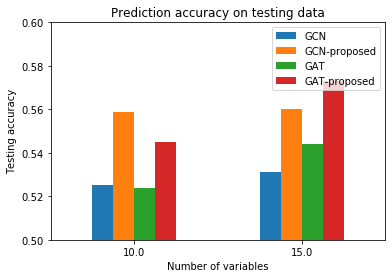

In [13]:

simu_result_0 = pd.DataFrame(columns=["d", "GCN", "GCN-proposed","GAT","GAT-proposed"])

simu_result_0.loc[0]=[10,0.525,0.559,0.524,0.545]
simu_result_0.loc[1]=[15,0.531,0.560,0.544,0.573]
# simu_result_0.loc[2]=[20,0.539,0.525,0.538,0.538]
ax = simu_result_0.plot(x="d", y=["GCN", "GCN-proposed","GAT","GAT-proposed"], kind="bar", rot=0)
_ = ax.legend( loc='upper right')
plt.ylim(0.5,0.6)
plt.xlabel("Number of variables")
plt.ylabel("Testing accuracy")
plt.title("Prediction accuracy on testing data")
plt.savefig("barplot_-0.3.pdf")

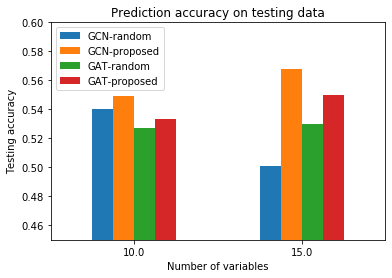

In [31]:
simu_result = pd.DataFrame(columns=["d", "GCN-random", "GCN-proposed","GAT-random","GAT-proposed"])

simu_result.loc[0]=[10,0.540,0.549,0.527,0.533]
simu_result.loc[1]=[15,0.501,0.568,0.530,0.550]

ax = simu_result.plot(x="d", y=["GCN-random", "GCN-proposed","GAT-random","GAT-proposed"], kind="bar", rot=0)
_ = ax.legend( loc='best')
plt.ylim(0.45,0.6)
plt.xlabel("Number of variables")
plt.ylabel("Testing accuracy")
plt.title("Prediction accuracy on testing data")
plt.savefig("barplot_-1_graph.pdf")

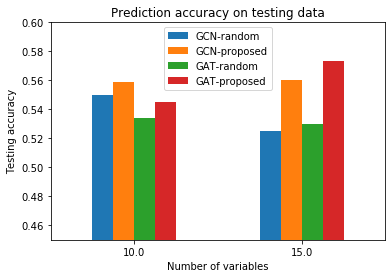

In [32]:
simu_result_0 = pd.DataFrame(columns=["d", "GCN-random", "GCN-proposed","GAT-random","GAT-proposed"])

simu_result_0.loc[0]=[10,0.550,0.559,0.534,0.545]
simu_result_0.loc[1]=[15,0.525,0.560,0.530,0.573]

ax = simu_result_0.plot(x="d", y=["GCN-random", "GCN-proposed","GAT-random","GAT-proposed"], kind="bar", rot=0)
_ = ax.legend( loc='best')
plt.ylim(0.45,0.6)
plt.xlabel("Number of variables")
plt.ylabel("Testing accuracy")
plt.title("Prediction accuracy on testing data")
plt.savefig("barplot_-0.3_graph.pdf")